# 2 Build a Multi-output Model

In this lab, we'll go over how to build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 960us/sample - loss: 245.0199 - y1_output_loss: 118.6397 - y2_output_loss: 124.1324 - y1_output_root_mean_squared_error: 10.9430 - y2_output_root_mean_squared_error: 11.1925 - val_loss: 25.5205 - val_y1_output_loss: 12.4725 - val_y2_output_loss: 13.1148 - val_y1_output_root_mean_squared_error: 3.5368 - val_y2_output_root_mean_squared_error: 3.6071
Epoch 2/500
614/614 [==============================] - 0s 157us/sample - loss: 32.1353 - y1_output_loss: 11.9867 - y2_output_loss: 19.8798 - y1_output_root_mean_squared_error: 3.4775 - y2_output_root_mean_squared_error: 4.4769 - val_loss: 20.9631 - val_y1_output_loss: 9.4275 - val_y2_output_loss: 11.7247 - val_y1_output_root_mean_squared_error: 3.0590 - val_y2_output_root_mean_squared_error: 3.4067
Epoch 3/500
614/614 [==============================] - 0s 140us/sample - loss: 28.5773 - y1_output_loss: 10.6148 - y2_output_loss: 18.0349 - y1_

614/614 [==============================] - 0s 138us/sample - loss: 7.8367 - y1_output_loss: 2.4819 - y2_output_loss: 5.2995 - y1_output_root_mean_squared_error: 1.5774 - y2_output_root_mean_squared_error: 2.3127 - val_loss: 7.3239 - val_y1_output_loss: 3.0411 - val_y2_output_loss: 4.1536 - val_y1_output_root_mean_squared_error: 1.7442 - val_y2_output_root_mean_squared_error: 2.0692
Epoch 42/500
614/614 [==============================] - 0s 146us/sample - loss: 7.9421 - y1_output_loss: 2.6657 - y2_output_loss: 5.3001 - y1_output_root_mean_squared_error: 1.6270 - y2_output_root_mean_squared_error: 2.3011 - val_loss: 12.8312 - val_y1_output_loss: 3.6795 - val_y2_output_loss: 8.9010 - val_y1_output_root_mean_squared_error: 1.9120 - val_y2_output_root_mean_squared_error: 3.0291
Epoch 43/500
614/614 [==============================] - 0s 132us/sample - loss: 7.5045 - y1_output_loss: 2.5027 - y2_output_loss: 4.9429 - y1_output_root_mean_squared_error: 1.5885 - y2_output_root_mean_squared_error

Epoch 62/500
614/614 [==============================] - 0s 145us/sample - loss: 6.9262 - y1_output_loss: 1.9316 - y2_output_loss: 4.9579 - y1_output_root_mean_squared_error: 1.3875 - y2_output_root_mean_squared_error: 2.2363 - val_loss: 3.5803 - val_y1_output_loss: 1.2814 - val_y2_output_loss: 2.2875 - val_y1_output_root_mean_squared_error: 1.1185 - val_y2_output_root_mean_squared_error: 1.5262
Epoch 63/500
614/614 [==============================] - 0s 133us/sample - loss: 4.1799 - y1_output_loss: 1.2206 - y2_output_loss: 2.9343 - y1_output_root_mean_squared_error: 1.1086 - y2_output_root_mean_squared_error: 1.7178 - val_loss: 3.9250 - val_y1_output_loss: 1.2232 - val_y2_output_loss: 2.6269 - val_y1_output_root_mean_squared_error: 1.1196 - val_y2_output_root_mean_squared_error: 1.6344
Epoch 64/500
614/614 [==============================] - 0s 133us/sample - loss: 4.5101 - y1_output_loss: 1.3259 - y2_output_loss: 3.1520 - y1_output_root_mean_squared_error: 1.1553 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 133us/sample - loss: 4.0476 - y1_output_loss: 0.9201 - y2_output_loss: 3.0968 - y1_output_root_mean_squared_error: 0.9628 - y2_output_root_mean_squared_error: 1.7665 - val_loss: 3.9522 - val_y1_output_loss: 1.3114 - val_y2_output_loss: 2.5778 - val_y1_output_root_mean_squared_error: 1.1466 - val_y2_output_root_mean_squared_error: 1.6241
Epoch 84/500
614/614 [==============================] - 0s 140us/sample - loss: 6.3503 - y1_output_loss: 1.4924 - y2_output_loss: 4.8037 - y1_output_root_mean_squared_error: 1.2268 - y2_output_root_mean_squared_error: 2.2012 - val_loss: 2.9492 - val_y1_output_loss: 0.7228 - val_y2_output_loss: 2.2197 - val_y1_output_root_mean_squared_error: 0.8537 - val_y2_output_root_mean_squared_error: 1.4901
Epoch 85/500
614/614 [==============================] - 0s 132us/sample - loss: 3.2085 - y1_output_loss: 0.7297 - y2_output_loss: 2.4689 - y1_output_root_mean_squared_error: 0.8571 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 129us/sample - loss: 3.3526 - y1_output_loss: 0.7712 - y2_output_loss: 2.6765 - y1_output_root_mean_squared_error: 0.8617 - y2_output_root_mean_squared_error: 1.6156 - val_loss: 13.3011 - val_y1_output_loss: 4.7856 - val_y2_output_loss: 8.0914 - val_y1_output_root_mean_squared_error: 2.2201 - val_y2_output_root_mean_squared_error: 2.8935
Epoch 105/500
614/614 [==============================] - 0s 128us/sample - loss: 3.0023 - y1_output_loss: 0.7757 - y2_output_loss: 2.2236 - y1_output_root_mean_squared_error: 0.8823 - y2_output_root_mean_squared_error: 1.4913 - val_loss: 1.9585 - val_y1_output_loss: 0.4991 - val_y2_output_loss: 1.4576 - val_y1_output_root_mean_squared_error: 0.7008 - val_y2_output_root_mean_squared_error: 1.2114
Epoch 106/500
614/614 [==============================] - 0s 129us/sample - loss: 2.7211 - y1_output_loss: 0.6136 - y2_output_loss: 2.1274 - y1_output_root_mean_squared_error: 0.7788 - y2_output_root_me

Epoch 145/500
614/614 [==============================] - 0s 133us/sample - loss: 2.1381 - y1_output_loss: 0.4188 - y2_output_loss: 1.7023 - y1_output_root_mean_squared_error: 0.6494 - y2_output_root_mean_squared_error: 1.3101 - val_loss: 1.3282 - val_y1_output_loss: 0.2669 - val_y2_output_loss: 1.0521 - val_y1_output_root_mean_squared_error: 0.5121 - val_y2_output_root_mean_squared_error: 1.0324
Epoch 146/500
614/614 [==============================] - 0s 133us/sample - loss: 2.1110 - y1_output_loss: 0.3978 - y2_output_loss: 1.7697 - y1_output_root_mean_squared_error: 0.6233 - y2_output_root_mean_squared_error: 1.3124 - val_loss: 17.6872 - val_y1_output_loss: 4.2342 - val_y2_output_loss: 12.8824 - val_y1_output_root_mean_squared_error: 2.0912 - val_y2_output_root_mean_squared_error: 3.6488
Epoch 147/500
614/614 [==============================] - 0s 128us/sample - loss: 3.8302 - y1_output_loss: 0.7686 - y2_output_loss: 3.0468 - y1_output_root_mean_squared_error: 0.8804 - y2_output_root_m

Epoch 186/500
614/614 [==============================] - 0s 140us/sample - loss: 1.4669 - y1_output_loss: 0.2792 - y2_output_loss: 1.1749 - y1_output_root_mean_squared_error: 0.5307 - y2_output_root_mean_squared_error: 1.0887 - val_loss: 1.4571 - val_y1_output_loss: 0.2580 - val_y2_output_loss: 1.1513 - val_y1_output_root_mean_squared_error: 0.5138 - val_y2_output_root_mean_squared_error: 1.0923
Epoch 187/500
614/614 [==============================] - 0s 139us/sample - loss: 1.2682 - y1_output_loss: 0.2539 - y2_output_loss: 1.0299 - y1_output_root_mean_squared_error: 0.5040 - y2_output_root_mean_squared_error: 1.0071 - val_loss: 1.5943 - val_y1_output_loss: 0.2495 - val_y2_output_loss: 1.3153 - val_y1_output_root_mean_squared_error: 0.5007 - val_y2_output_root_mean_squared_error: 1.1591
Epoch 188/500
614/614 [==============================] - 0s 136us/sample - loss: 2.1226 - y1_output_loss: 0.4951 - y2_output_loss: 1.6589 - y1_output_root_mean_squared_error: 0.7058 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 139us/sample - loss: 1.4939 - y1_output_loss: 0.2817 - y2_output_loss: 1.2126 - y1_output_root_mean_squared_error: 0.5314 - y2_output_root_mean_squared_error: 1.1007 - val_loss: 2.3317 - val_y1_output_loss: 0.3312 - val_y2_output_loss: 1.9696 - val_y1_output_root_mean_squared_error: 0.5829 - val_y2_output_root_mean_squared_error: 1.4114
Epoch 228/500
614/614 [==============================] - 0s 136us/sample - loss: 1.0368 - y1_output_loss: 0.2240 - y2_output_loss: 0.8089 - y1_output_root_mean_squared_error: 0.4724 - y2_output_root_mean_squared_error: 0.9020 - val_loss: 1.4587 - val_y1_output_loss: 0.2519 - val_y2_output_loss: 1.1946 - val_y1_output_root_mean_squared_error: 0.5099 - val_y2_output_root_mean_squared_error: 1.0949
Epoch 229/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9501 - y1_output_loss: 0.1920 - y2_output_loss: 0.7563 - y1_output_root_mean_squared_error: 0.4401 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 141us/sample - loss: 0.8904 - y1_output_loss: 0.1931 - y2_output_loss: 0.6937 - y1_output_root_mean_squared_error: 0.4405 - y2_output_root_mean_squared_error: 0.8344 - val_loss: 1.2245 - val_y1_output_loss: 0.1771 - val_y2_output_loss: 1.0136 - val_y1_output_root_mean_squared_error: 0.4265 - val_y2_output_root_mean_squared_error: 1.0211
Epoch 269/500
614/614 [==============================] - 0s 138us/sample - loss: 1.0179 - y1_output_loss: 0.1931 - y2_output_loss: 0.8193 - y1_output_root_mean_squared_error: 0.4389 - y2_output_root_mean_squared_error: 0.9084 - val_loss: 1.5204 - val_y1_output_loss: 0.3460 - val_y2_output_loss: 1.1799 - val_y1_output_root_mean_squared_error: 0.5918 - val_y2_output_root_mean_squared_error: 1.0817
Epoch 270/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9273 - y1_output_loss: 0.1849 - y2_output_loss: 0.7465 - y1_output_root_mean_squared_error: 0.4295 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 133us/sample - loss: 0.7488 - y1_output_loss: 0.1919 - y2_output_loss: 0.5571 - y1_output_root_mean_squared_error: 0.4352 - y2_output_root_mean_squared_error: 0.7479 - val_loss: 1.2430 - val_y1_output_loss: 0.3884 - val_y2_output_loss: 0.8212 - val_y1_output_root_mean_squared_error: 0.6331 - val_y2_output_root_mean_squared_error: 0.9177
Epoch 310/500
614/614 [==============================] - 0s 135us/sample - loss: 0.6196 - y1_output_loss: 0.1547 - y2_output_loss: 0.4631 - y1_output_root_mean_squared_error: 0.3933 - y2_output_root_mean_squared_error: 0.6819 - val_loss: 1.0332 - val_y1_output_loss: 0.1845 - val_y2_output_loss: 0.8499 - val_y1_output_root_mean_squared_error: 0.4334 - val_y2_output_root_mean_squared_error: 0.9195
Epoch 311/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6828 - y1_output_loss: 0.1787 - y2_output_loss: 0.5013 - y1_output_root_mean_squared_error: 0.4218 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 140us/sample - loss: 0.8404 - y1_output_loss: 0.2054 - y2_output_loss: 0.6307 - y1_output_root_mean_squared_error: 0.4525 - y2_output_root_mean_squared_error: 0.7973 - val_loss: 0.8946 - val_y1_output_loss: 0.3117 - val_y2_output_loss: 0.5981 - val_y1_output_root_mean_squared_error: 0.5595 - val_y2_output_root_mean_squared_error: 0.7626
Epoch 351/500
614/614 [==============================] - 0s 137us/sample - loss: 0.7589 - y1_output_loss: 0.1967 - y2_output_loss: 0.5591 - y1_output_root_mean_squared_error: 0.4444 - y2_output_root_mean_squared_error: 0.7493 - val_loss: 0.9437 - val_y1_output_loss: 0.1752 - val_y2_output_loss: 0.7938 - val_y1_output_root_mean_squared_error: 0.4162 - val_y2_output_root_mean_squared_error: 0.8777
Epoch 352/500
614/614 [==============================] - 0s 133us/sample - loss: 0.5573 - y1_output_loss: 0.1571 - y2_output_loss: 0.3991 - y1_output_root_mean_squared_error: 0.3955 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5243 - y1_output_loss: 0.1383 - y2_output_loss: 0.3813 - y1_output_root_mean_squared_error: 0.3733 - y2_output_root_mean_squared_error: 0.6204 - val_loss: 0.6768 - val_y1_output_loss: 0.1534 - val_y2_output_loss: 0.5187 - val_y1_output_root_mean_squared_error: 0.3962 - val_y2_output_root_mean_squared_error: 0.7210
Epoch 392/500
614/614 [==============================] - 0s 138us/sample - loss: 0.3785 - y1_output_loss: 0.1284 - y2_output_loss: 0.2527 - y1_output_root_mean_squared_error: 0.3599 - y2_output_root_mean_squared_error: 0.4990 - val_loss: 1.3025 - val_y1_output_loss: 0.2375 - val_y2_output_loss: 1.0407 - val_y1_output_root_mean_squared_error: 0.4919 - val_y2_output_root_mean_squared_error: 1.0298
Epoch 393/500
614/614 [==============================] - 0s 139us/sample - loss: 0.6282 - y1_output_loss: 0.1402 - y2_output_loss: 0.4862 - y1_output_root_mean_squared_error: 0.3758 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 133us/sample - loss: 0.3966 - y1_output_loss: 0.1364 - y2_output_loss: 0.2585 - y1_output_root_mean_squared_error: 0.3688 - y2_output_root_mean_squared_error: 0.5105 - val_loss: 0.7395 - val_y1_output_loss: 0.1801 - val_y2_output_loss: 0.5866 - val_y1_output_root_mean_squared_error: 0.4223 - val_y2_output_root_mean_squared_error: 0.7491
Epoch 433/500
614/614 [==============================] - 0s 140us/sample - loss: 0.3430 - y1_output_loss: 0.1176 - y2_output_loss: 0.2244 - y1_output_root_mean_squared_error: 0.3437 - y2_output_root_mean_squared_error: 0.4741 - val_loss: 0.6352 - val_y1_output_loss: 0.1600 - val_y2_output_loss: 0.4807 - val_y1_output_root_mean_squared_error: 0.3990 - val_y2_output_root_mean_squared_error: 0.6899
Epoch 434/500
614/614 [==============================] - 0s 133us/sample - loss: 0.3845 - y1_output_loss: 0.1269 - y2_output_loss: 0.2591 - y1_output_root_mean_squared_error: 0.3572 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3518 - y1_output_loss: 0.1200 - y2_output_loss: 0.2310 - y1_output_root_mean_squared_error: 0.3453 - y2_output_root_mean_squared_error: 0.4822 - val_loss: 0.7878 - val_y1_output_loss: 0.3149 - val_y2_output_loss: 0.4702 - val_y1_output_root_mean_squared_error: 0.5627 - val_y2_output_root_mean_squared_error: 0.6865
Epoch 474/500
614/614 [==============================] - 0s 134us/sample - loss: 0.3254 - y1_output_loss: 0.1140 - y2_output_loss: 0.2091 - y1_output_root_mean_squared_error: 0.3392 - y2_output_root_mean_squared_error: 0.4587 - val_loss: 0.6756 - val_y1_output_loss: 0.1972 - val_y2_output_loss: 0.4804 - val_y1_output_root_mean_squared_error: 0.4448 - val_y2_output_root_mean_squared_error: 0.6912
Epoch 475/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3512 - y1_output_loss: 0.1167 - y2_output_loss: 0.2487 - y1_output_root_mean_squared_error: 0.3418 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 36us/sample - loss: 1.0965 - y1_output_loss: 0.2073 - y2_output_loss: 0.8921 - y1_output_root_mean_squared_error: 0.4573 - y2_output_root_mean_squared_error: 0.9420
Loss = 1.0965167547201182, Y1_loss = 0.20725710690021515, Y1_mse = 0.4572712779045105, Y2_loss = 0.8920964002609253, Y2_mse = 0.942029595375061


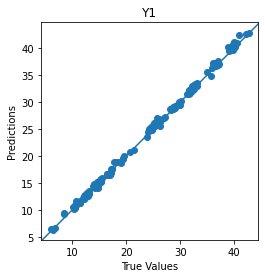

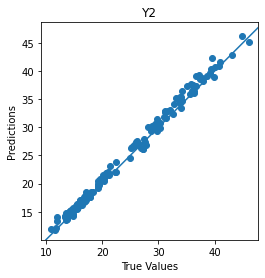

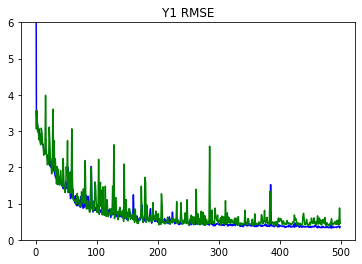

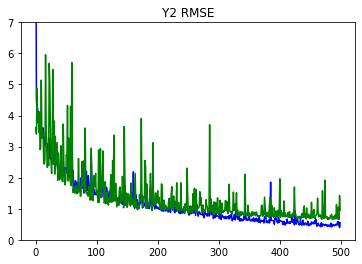

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)